# Figure 1
- Most adhesome genes are active
- Active adhesome genes are close in Hi-C maps

### Setup

In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures0/correlation_clustering.py'>

In [2]:
# Specify all directories

# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Load adhesome components

In [4]:
# Load components
components_filename = 'components.csv'
df_components = pd.read_csv(dir_adhesome+components_filename, sep = ',', header = 0)
print('Number of components: '+str(len(df_components)))
print('Number of intrinsic components: '+str(len(df_components[df_components['FA']=='Intrinsic Proteins'])))
print('Number of associated components: '+str(len(df_components[df_components['FA']=='Associated Proteins'])))
df_components.head()

Number of components: 232
Number of intrinsic components: 150
Number of associated components: 82


,Official Symbol,Gene ID,Protein name,Swiss-Prot ID,Synonyms,Functional Category,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


### Determine active and inactive loci

In [5]:
# collect normalized epigenomic data across all chromosomes into one dataframe
df_all_norm = pd.DataFrame()
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    df_chipseq_norm = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'_norm.csv', header=0, index_col = 0)
    df_chipseq_norm.columns = 'chr_'+str(chrom)+'_loc_'+np.array(df_chipseq_norm.columns)
    # Concatenate to data for previous chromosomes
    df_all_norm = pd.concat([df_all_norm, df_chipseq_norm],axis=1)
df_all_norm

,chr_1_loc_0,chr_1_loc_250000,chr_1_loc_500000,chr_1_loc_750000,chr_1_loc_1000000,chr_1_loc_1250000,chr_1_loc_1500000,chr_1_loc_1750000,chr_1_loc_2000000,chr_1_loc_2250000,...,chr_22_loc_49000000,chr_22_loc_49250000,chr_22_loc_49500000,chr_22_loc_49750000,chr_22_loc_50000000,chr_22_loc_50250000,chr_22_loc_50500000,chr_22_loc_50750000,chr_22_loc_51000000,chr_22_loc_51250000
H3K4me1,-1.008735,-2.015639,-0.505283,0.796121,0.699133,0.699133,0.765209,0.699133,0.645307,0.868093,...,-2.015639,-1.512187,-2.015639,-2.015639,0.322319,0.663696,0.920941,0.699133,0.780829,-2.015639
H3K4me2,-1.958933,-1.958933,-0.780395,0.903726,0.629325,0.777549,0.960422,1.110838,1.155592,0.587846,...,-1.958933,-1.369664,-1.958933,-1.958933,0.398144,0.706663,0.706663,0.842976,0.668873,-1.958933
H3K4me3,-0.762508,-1.559915,-0.296056,2.096163,2.047202,2.188246,1.942547,1.629711,2.096163,1.555465,...,-1.559915,-0.762508,-1.559915,-1.559915,1.089012,1.555465,2.096163,1.699454,2.047202,-1.559915
H3K36me3,-0.846516,-1.915456,0.502253,1.085439,0.909434,0.732414,1.053306,0.966577,0.947996,0.756895,...,-0.221226,0.119462,-0.312046,-0.221226,0.269171,0.756895,0.825993,0.780622,1.019776,-1.915456
H3K9ac,-2.030991,-3.572735,-1.408623,1.086720,1.328125,1.152158,1.381093,1.314479,1.152158,1.286674,...,-1.129128,-1.011953,-1.011953,-1.260118,0.635789,0.709143,1.183488,1.341605,0.943019,-3.572735
POLR2A,-0.789470,-0.789470,0.148832,3.123182,2.327504,2.456524,1.636007,1.389201,2.456524,1.636007,...,-0.789470,-0.789470,-0.789470,-0.789470,1.636007,1.636007,1.389201,2.184879,0.148832,-0.789470
H3K9me3,-4.012477,-6.973887,-3.677000,-0.596838,-0.485287,-1.461657,-1.556038,0.620154,-0.485287,-0.329699,...,-1.655523,-1.126180,-1.556038,-1.655523,-0.186247,0.030477,-0.186247,-1.051067,0.260780,-6.973887
H3K27me3,-0.207024,-1.800421,-1.297760,0.641495,0.407424,0.295636,-0.501062,0.407424,0.372042,0.562305,...,-1.800421,-1.800421,-1.800421,-1.297760,0.562305,0.210222,0.616047,0.254186,0.798297,-1.800421
RNAseq,-0.580582,-1.212921,0.481148,1.608928,1.932739,1.820298,1.605801,1.055406,0.703510,1.027435,...,-0.630660,-0.515558,-1.436824,-1.274597,0.548814,1.118235,1.479756,1.333030,0.878212,-1.991482
ATACseq,-0.649909,-1.994005,-1.994005,1.160163,1.077385,1.148882,1.051953,0.844721,0.984326,0.925460,...,-1.474038,-1.994005,-0.534272,1.038907,0.984326,1.113985,1.077385,-0.434103,-1.994005,-1.994005


In [6]:
# Hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(df_all_norm.T)
print('Total number of loci = '+str(len(clustering.labels_)))
print('Number of loci in cluster 0 = '+str(np.sum(clustering.labels_==0)))
print('Number of loci in cluster 1 = '+str(np.sum(clustering.labels_==1)))

Total number of loci = 11537
Number of loci in cluster 0 = 5085
Number of loci in cluster 1 = 6452


In [7]:
# Load adhesome loci and add column to df_clusters
df_clusters = pickle.load(open(saving_dir+'df_clusters0.pkl', 'rb'))
adhesome_loci = pickle.load(open(saving_dir+'adhesome_loci_list.pkl', 'rb'))
df_clusters['adhesome_locus'] = 0
df_clusters.loc[adhesome_loci,'adhesome_locus'] = 1
df_clusters['type'] = [['inactive','active'][i] for i in df_clusters['cluster']]
pickle.dump(df_clusters, open(saving_dir+'active_inactive_loci.pkl', 'wb'))
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2,adhesome_locus,type
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,-48.559505,18.347490,0,inactive
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,-65.415192,7.989654,0,inactive
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,-42.624043,16.534678,0,inactive
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,-8.953670,-84.428932,0,active
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,-9.167767,-81.599449,0,active


In [8]:
# Number of active/inactive adhesome loci
n_adhesome_active = len(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)])
n_adhesome_inactive = len(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)])
print('Numer of active adhesome loci = '+str(n_adhesome_active))
print('Numer of inactive adhesome loci = '+str(n_adhesome_inactive))

Numer of active adhesome loci = 281
Numer of inactive adhesome loci = 16


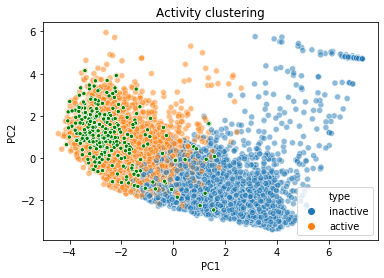

In [9]:
# Plot PC1 and PC2
%matplotlib inline
plt.figure()
sns.scatterplot(x="PC1", y="PC2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="PC1", y="PC2", data=df_clusters[df_clusters['adhesome_locus']==1], 
                size=0.1, color='green',legend=False)
plt.title('Activity clustering')
plt.show()

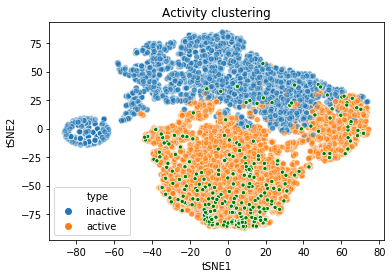

In [10]:
# Plot tSNE1 and tSNE2
%matplotlib inline
plt.figure()
sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['adhesome_locus']==1], 
                size=0.1, color='green',legend=False)
plt.title('Activity clustering')
plt.show()

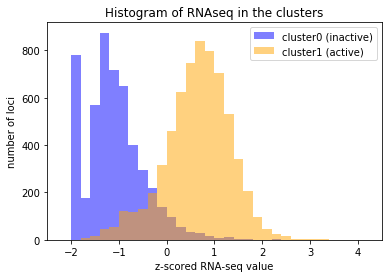

In [11]:
# Distribution of RNAseq in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='blue', alpha=0.5, density=False, label='cluster0 (inactive)')
plt.hist(df_clusters.loc[df_clusters['cluster']==1]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='orange', alpha=0.5, density=False, label='cluster1 (active)')
#plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['RNAseq'], 
#            np.zeros(n_adhesome_inactive)-20, color='blue', alpha=0.5, s=1)
#plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['RNAseq'], 
#            np.zeros(n_adhesome_active)-10, color='orange', alpha=0.5, s=1)
plt.xlim(-2.5,4.5)
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('number of loci')
plt.title('Histogram of RNAseq in the clusters')
plt.legend(loc='upper right')
plt.show()

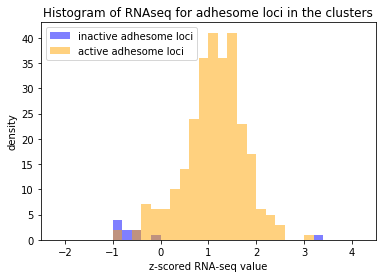

In [12]:
# Distribution of RNA-seq in clusters for adhesome loci only
%matplotlib inline
plt.figure()
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='blue', alpha=0.5, density=False, label='inactive adhesome loci')
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='orange', alpha=0.5, density=False, label='active adhesome loci')
plt.xlim(-2.5,4.5)
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('density')
plt.title('Histogram of RNAseq for adhesome loci in the clusters')
plt.legend(loc='upper left')
plt.show()

In [13]:
# Save all active/inactive loci to pickle
all_active_loci = df_clusters[df_clusters['type']=='active'].index.tolist()
pickle.dump(all_active_loci ,open(saving_dir+'all_active_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
all_inactive_loci = df_clusters[df_clusters['type']=='inactive'].index.tolist()
pickle.dump(all_inactive_loci ,open(saving_dir+'all_inactive_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

### Import adhesome loci

In [14]:
# Load adhesome components data
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = lu.load_adhesome_data(adhesome_components_filename)
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_gene_locations(gene_locations_filename, gene_id_filename)
# Find location of adhesome genes
adhesome_loc_df, missing_adhesome_genes = lu.get_adhesome_genes_location(df_components, df_loc)
adhesome_loc_df = lu.get_adhesome_genes_loci(adhesome_loc_df, resol)
adhesome_loc_df['chrom_int'] = adhesome_loc_df['chrom'].str.split('chr').str[1].astype(int)
adhesome_genes = np.unique(adhesome_loc_df['gene'])
print('Final number of adhesome genes = '+str(len(adhesome_genes)))
# Construct data frame annotating each adhesome locus with gene
adhesome_chr_loci = adhesome_loc_df[['chrom','chrom_int','loci','gene']]
adhesome_chr_loci = adhesome_chr_loci.sort_values(['chrom_int','loci'])
adhesome_loci = [adhesome_chr_loci.iloc[i]['chrom']+'_'+'loc'+str(adhesome_chr_loci.iloc[i]['loci']*resol) 
                 for i in range(len(adhesome_chr_loci))]
# Add locus ID column
adhesome_chr_loci['locus_id'] = ['chr_'+str(adhesome_chr_loci.iloc[i]['chrom_int'])+'_loc_'
                                 +str(adhesome_chr_loci.iloc[i]['loci']*resol) 
                                 for i in range(len(adhesome_chr_loci))]
pickle.dump(adhesome_chr_loci, open(saving_dir+'adhesome_chr_loci.pkl', 'wb'))
# Visualize head of adhesome_chr_loci
print('Number of adhesome loci = '+str(len(adhesome_loci)))
adhesome_chr_loci.head()

Adhesome genes absent from UCSC genes: ['JUB', 'SH3KBP1', 'MSN', 'GRLF1', 'FLNA', 'ITGAW', 'SMPX', 'DDEF1', 'PPP2CA', 'ARHGEF6']
Final number of adhesome genes = 222
Number of adhesome loci = 305


,chrom,chrom_int,loci,gene,locus_id
34,chr1,1,64,FBLIM1,chr_1_loc_16000000
97,chr1,1,95,ASAP3,chr_1_loc_23750000
173,chr1,1,109,SLC9A1,chr_1_loc_27250000
158,chr1,1,127,FABP3,chr_1_loc_31750000
139,chr1,1,158,MACF1,chr_1_loc_39500000


In [15]:
# List of all adhesome genes
all_adhesome_genes = np.unique(adhesome_chr_loci['gene'].values)
pickle.dump(all_adhesome_genes ,open(saving_dir+'all_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
adhesome_chr_loci.head()

,chrom,chrom_int,loci,gene,locus_id
34,chr1,1,64,FBLIM1,chr_1_loc_16000000
97,chr1,1,95,ASAP3,chr_1_loc_23750000
173,chr1,1,109,SLC9A1,chr_1_loc_27250000
158,chr1,1,127,FABP3,chr_1_loc_31750000
139,chr1,1,158,MACF1,chr_1_loc_39500000


In [17]:
# Dictionary with adhesome locus as key and adhesome gene as value
adhesome_chr_loci_bis = adhesome_chr_loci.groupby('locus_id')['gene'].apply(lambda x: '_'.join(x)).reset_index()
adhesome_locus_gene_dict = {adhesome_chr_loci_bis.iloc[i,0]:adhesome_chr_loci_bis.iloc[i,1] 
                            for i in np.arange(len(adhesome_chr_loci_bis))}
# Dictionary with adhesome gene as key and adhesome locus as value
adhesome_chr_loci_ter = adhesome_chr_loci.groupby('gene')['locus_id'].apply(lambda x: '_x_'.join(x)).reset_index()
adhesome_gene_locus_dict = {adhesome_chr_loci_ter.iloc[i,0]:adhesome_chr_loci_ter.iloc[i,1] 
                            for i in np.arange(len(adhesome_chr_loci_ter))}

### Identify active/inactive adhesome loci

In [18]:
# Load annotated loci across all genome
df_clusters = pickle.load(open(saving_dir+'active_inactive_loci.pkl', 'rb'))
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2,adhesome_locus,type
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,-48.559505,18.347490,0,inactive
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,-65.415192,7.989654,0,inactive
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,-42.624043,16.534678,0,inactive
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,-8.953670,-84.428932,0,active
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,-9.167767,-81.599449,0,active


In [19]:
# All loci in genome
all_loci = set(df_clusters.index)
pickle.dump(all_loci ,open(saving_dir+'all_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Total number of loci in genome = '+str(len(all_loci)))
# Active loci correspond to cluster 1
active_loci = list(df_clusters[df_clusters['cluster']==1].index)
pickle.dump(active_loci ,open(saving_dir+'active_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Number of active loci in genome: '+str(len(active_loci)))
# Inactive loci correspond to cluster 0
inactive_loci = list(df_clusters[df_clusters['cluster']==0].index)
pickle.dump(inactive_loci ,open(saving_dir+'inactive_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Number of inactive loci in genome: '+str(len(inactive_loci)))

Total number of loci in genome = 11537
Number of active loci in genome: 6452
Number of inactive loci in genome: 5085


In [20]:
# Dictionary of active loci for each chromosome
active_loci_dict = dict()
for chrom in range(1,22+1):
    active_loci_dict[chrom] = ([int(s.split('_')[3]) for s in active_loci if 'chr_'+str(chrom)+'_' in s])
pickle.dump(active_loci_dict ,open(saving_dir+'active_loci_dict.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# Identify all/active/inactive adhesome genes in the genome
pickle.dump(adhesome_genes ,open(saving_dir+'adhesome_genes_list.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
active_adhesome_genes = np.unique(adhesome_chr_loci[adhesome_chr_loci['locus_id'].isin(active_loci)]['gene'].values)
pickle.dump(active_adhesome_genes ,open(saving_dir+'active_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
inactive_adhesome_genes = np.unique(adhesome_chr_loci[adhesome_chr_loci['locus_id'].isin(inactive_loci)]['gene'].values)
pickle.dump(inactive_adhesome_genes ,open(saving_dir+'inactive_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

### Active/inactive adhesome loci per chromosome

In [22]:
# Add activity column to adhesome_chr_loci
adhesome_chr_loci['active'] = [adhesome_chr_loci.iloc[i]['locus_id'] in active_loci 
                               for i in range(len(adhesome_chr_loci))]
adhesome_chr_loci.to_csv(saving_dir+'adhesome_loci_activity.csv', header=True)
pickle.dump(adhesome_chr_loci ,open(saving_dir+'adhesome_chr_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# All adhesome loci
adhesome_chr_loci_unique = adhesome_chr_loci.drop_duplicates(subset='locus_id')
adhesome_loci_list = adhesome_chr_loci_unique['locus_id'].tolist()
pickle.dump(adhesome_loci_list ,open(saving_dir+'adhesome_loci_list.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
# Active adhesome loci
active_adhesome_loci = adhesome_chr_loci_unique[adhesome_chr_loci_unique['active']==True]['locus_id'].values
pickle.dump(active_adhesome_loci ,open(saving_dir+'active_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
# Inactive adhesome loci
inactive_adhesome_loci = adhesome_chr_loci_unique[adhesome_chr_loci_unique['active']==False]['locus_id'].values
pickle.dump(inactive_adhesome_loci ,open(saving_dir+'inactive_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

Number of active adhesome loci = 281
Number of inactive adhesome loci = 16


<Figure size 432x288 with 0 Axes>

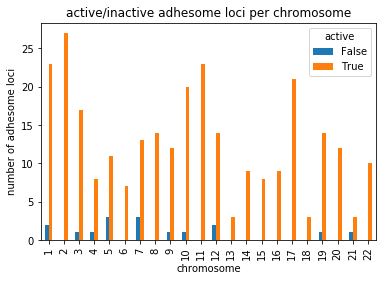

In [24]:
# Basic statistics
print('Number of active adhesome loci = '+str(len(active_adhesome_loci)))
print('Number of inactive adhesome loci = '+str(len(inactive_adhesome_loci)))
# Plot number of active/inactive adhesome loci for all chromosomes
df_bar = adhesome_chr_loci_unique.groupby(['chrom_int'])
df_bar1 = df_bar['active'].value_counts().unstack()
plt.figure()
df_bar1.plot(kind='bar', title='active/inactive adhesome loci per chromosome')
plt.xlabel('chromosome')
plt.ylabel('number of adhesome loci')
plt.show()

### Compare to random loci

In [25]:
# Create a dictionary of all non-adhesome, non adhesome-targeting TF active loci for each chromosome
all_active_loci_without_adhesome = list(set(active_loci)-set(active_adhesome_loci))
active_loci_pool = {chrom: [locus for locus in all_active_loci_without_adhesome if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}
# Create a dictionary of all non-adhesome, non adhesome-targeting TF iactive loci for each chromosome
all_inactive_loci_without_adhesome = list(set(inactive_loci)-set(inactive_adhesome_loci))
inactive_loci_pool = {chrom: [locus for locus in all_inactive_loci_without_adhesome if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}

In [26]:
# List of all active adhesome genes
number_active_adhesome_per_chrom = {chrom: len([locus for locus in active_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}
number_inactive_adhesome_per_chrom = {chrom: len([locus for locus in inactive_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}

In [27]:
# Create list out of all adhesome and random groups of loci
random_active_non_adhesome_loci = np.array(pickle.load(open(saving_dir+'random_active_non_adhesome_loci.pkl', 'rb')))
random_inactive_non_adhesome_loci = np.array(pickle.load(open(saving_dir+'random_inactive_non_adhesome_loci.pkl', 'rb')))
# Group all loci list by chromosome
active_adhesome_loci = active_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in active_adhesome_loci])]
inactive_adhesome_loci = inactive_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in inactive_adhesome_loci])]
random_active_non_adhesome_loci = random_active_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in random_active_non_adhesome_loci])]
random_inactive_non_adhesome_loci = random_inactive_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in random_inactive_non_adhesome_loci])]
# Create combined list
loci_list = list(itertools.chain.from_iterable([active_adhesome_loci,
                                                inactive_adhesome_loci,
                                                random_active_non_adhesome_loci,
                                                random_inactive_non_adhesome_loci]))

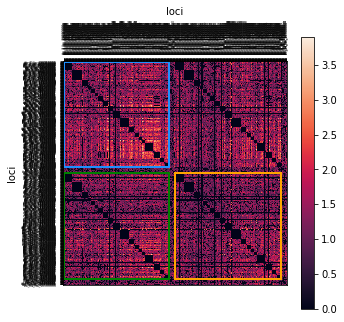

In [28]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[0,1,len(active_adhesome_loci), len(active_adhesome_loci),'dodgerblue'],
                [len(active_adhesome_loci)+len(inactive_adhesome_loci),len(active_adhesome_loci)+len(inactive_adhesome_loci),len(active_adhesome_loci),len(active_adhesome_loci),'orange'],
                [0, len(active_adhesome_loci)+len(inactive_adhesome_loci),len(random_active_non_adhesome_loci),len(random_active_non_adhesome_loci),'green']]
lu.plot_heatmap(contacts_df1, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df1.max().max(), add_patches = patches_list)

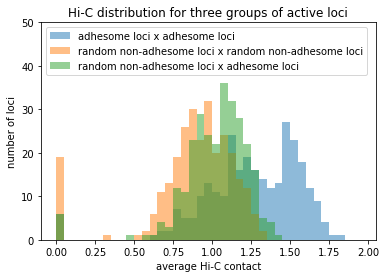

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=13.98403678358168, pvalue=1.951003771722823e-44)


In [29]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome loci with itself
active_adhesome_hic_with_itself = contacts_df1.loc[active_adhesome_loci,active_adhesome_loci].mean(axis=1)
# Group of random active non-adhesome loci with itself
random_active_adhesome_hic_with_itself = contacts_df1.loc[random_active_non_adhesome_loci,random_active_non_adhesome_loci].mean(axis=1)
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_active = contacts_df1.loc[active_adhesome_loci,random_active_non_adhesome_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.hist(random_versus_adhesome_active, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,50)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(active_adhesome_hic_with_itself.values,
                  random_active_adhesome_hic_with_itself))

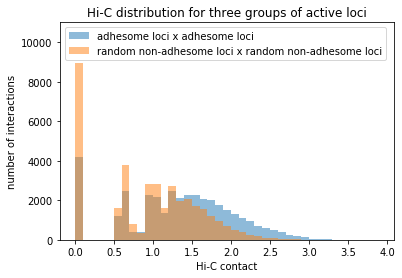

In [30]:
# Histogram of average Hi-C contacts in three active cases
indices = np.triu_indices(len(contacts_df1.loc[active_adhesome_loci,active_adhesome_loci]))
num_zeros_intraX = sum([int(number_active_adhesome_per_chrom[chrom]*(number_active_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
# Group of active adhesome loci with itself
active_adhesome_hic_with_itself = sorted(contacts_df1.loc[active_adhesome_loci,
                                                   active_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with itself
random_active_adhesome_hic_with_itself = sorted(contacts_df1.loc[random_active_non_adhesome_loci,
                                                          random_active_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_active = sorted(contacts_df1.loc[active_adhesome_loci,
                                                 random_active_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_active_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
#plt.vlines(x=1.5, ymin=0, ymax=9000, color='red', linestyle='dashed')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,11000)
plt.legend(loc='upper left')
plt.show()

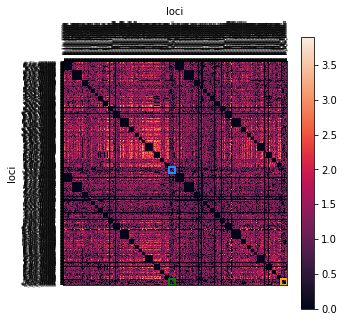

In [31]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[len(active_adhesome_loci), len(active_adhesome_loci),len(inactive_adhesome_loci),len(inactive_adhesome_loci),'dodgerblue'],
                [len(active_adhesome_loci)+len(inactive_adhesome_loci)+len(random_active_non_adhesome_loci),len(active_adhesome_loci)+len(inactive_adhesome_loci)+len(random_active_non_adhesome_loci),len(random_inactive_non_adhesome_loci),len(random_inactive_non_adhesome_loci),'orange'],
                [len(active_adhesome_loci),len(active_adhesome_loci)+len(inactive_adhesome_loci)+len(random_active_non_adhesome_loci),len(random_inactive_non_adhesome_loci),len(random_inactive_non_adhesome_loci),'green']]
lu.plot_heatmap(contacts_df1, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df1.max().max(), add_patches = patches_list)

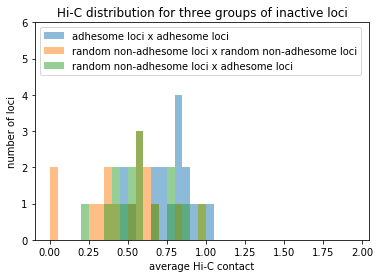

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=3.0528023638498567, pvalue=0.0022671520041358897)


In [32]:
# Histogram of average Hi-C contacts in three inactive cases
# Group of inactive adhesome loci with itself
inactive_adhesome_hic_with_itself = contacts_df1.loc[inactive_adhesome_loci,inactive_adhesome_loci].mean(axis=1)
# Group of random inactive non-adhesome loci with itself
random_inactive_adhesome_hic_with_itself = contacts_df1.loc[random_inactive_non_adhesome_loci,random_inactive_non_adhesome_loci].mean(axis=1)
# Group of random inactive non-adhesome loci with inactive adhesome loci
random_versus_adhesome_inactive = contacts_df1.loc[inactive_adhesome_loci,random_inactive_non_adhesome_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.hist(random_versus_adhesome_inactive, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of inactive loci')
plt.ylim(0,6)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(inactive_adhesome_hic_with_itself.values,
                  random_inactive_adhesome_hic_with_itself))

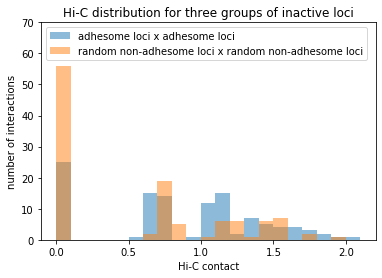

In [33]:
# Histogram of average Hi-C contacts in three active cases
indices = np.triu_indices(len(contacts_df1.loc[inactive_adhesome_loci,inactive_adhesome_loci]))
num_zeros_intraX = sum([int(number_inactive_adhesome_per_chrom[chrom]*(number_inactive_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
# Group of active adhesome loci with itself
inactive_adhesome_hic_with_itself = sorted(contacts_df1.loc[inactive_adhesome_loci,
                                                   inactive_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with itself
random_inactive_adhesome_hic_with_itself = sorted(contacts_df1.loc[random_inactive_non_adhesome_loci,
                                                          random_inactive_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Histogram
plt.figure()
plt.hist(inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2.2,0.1), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2.2,0.1), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of inactive loci')
plt.ylim(0,70)
plt.legend(loc='upper left')
plt.show()

### Supplement: show HiC connections between chromosomes

In [34]:
# Initialize empty dataframe
chr_list = np.arange(1,22+1)
chr_hic_contact = pd.DataFrame(0,index=chr_list, columns=chr_list)

In [35]:
# List all chromosome pairs
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))
    # Fill chr_hic_contact with the average Hi-C contact between chr1 and chr2
    chr_hic_contact.loc[chr1,chr2] = hic_chpair_df.mean().mean()
    chr_hic_contact.loc[chr2,chr1] = hic_chpair_df.mean().mean()

100%|██████████| 231/231 [00:03<00:00, 71.01it/s]


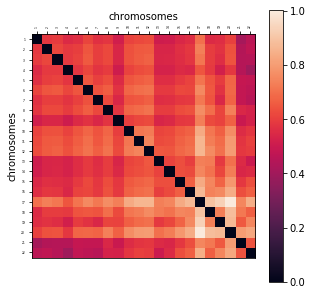

In [36]:
# Plot average HiC contact between all pairs of chromosomes
lu.plot_heatmap(chr_hic_contact, chr_list, chr_list, 'chromosomes', 'chromosomes', 
                5, chr_hic_contact.max().max())

# Network analysis

### Network of adhesome genes: interX edges

### Network of adhesome genes: intraX edges

### Network of adhesome genes: interX and intraX

In [37]:
# Load edge lists
adhesome_interX_edge_list = pickle.load(open(saving_dir+'adhesome_interX_edge_list.pkl', 'rb'))
adhesome_intraX_edge_list = pickle.load(open(saving_dir+'adhesome_intraX_edge_list.pkl', 'rb'))

### Genomic features for each adhesome gene

In [38]:
# Load pairwise Spearman correlations between adhesome genes
adhesome_loc_corr = pickle.load(open(saving_dir+'adhesome_loc_corr.pkl','rb'))

In [39]:
# Add Spearman correlation to interX edge list
adhesome_interX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                    adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
adhesome_interX_edge_list.head()

,source,target,hic,scaled_hic,spearman_corr
0,ABI1,ABI2,0.913088,0.120655,0.440947
1,ABI1,ABL1,0.874730,0.109367,0.313721
2,ABI1,ACTB,1.079872,0.169735,-0.273448
3,ABI1,ACTN1,1.480107,0.287516,-0.087169
4,ABI1,AGAP2,0.672833,0.049953,-0.365067


In [40]:
# Add Spearman correlation to intraX edge list
adhesome_intraX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                    adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]
adhesome_intraX_edge_list.head()

,source,target,hic,chrom,gen_dist,scaled_hic,spearman_corr
0,ABI1,ADAM12,2.312062,10,403.188976,0.135472,0.013026
1,ABI1,DOCK1,2.671161,10,407.318524,0.178049,0.402736
2,ABI1,LDB3,3.537248,10,245.477418,0.280739,-0.267260
3,ABI1,MAPK8,4.011600,10,90.134594,0.336982,0.291468
4,ABI1,NRP1,4.410741,10,25.809422,0.384307,0.059162


# Clustering analysis 1/4

### Construct network

In [348]:
# Select only top interX and intraX edges
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],0.75)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],0.75)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
print('Number of interX edges selected = '+str(len(inter_selected)))
print('Number of intraX edges selected = '+str(len(intra_selected)))
#adhesome_edge_list = pd.concat([inter_selected,intra_selected])
adhesome_edge_list = inter_selected
adhesome_edge_list.head()

Number of interX edges selected = 5139
Number of intraX edges selected = 261


,source,target,hic,scaled_hic,spearman_corr
68,ABI1,ITGAE,2.056018,0.456993,-0.206470
96,ABI1,MMP14,2.165441,0.489193,0.089774
101,ABI1,NEDD9,1.957505,0.428003,0.136887
106,ABI1,NUDT16L1,2.114121,0.474091,-0.365067
132,ABI1,PTPN11,1.927031,0.419035,0.337386


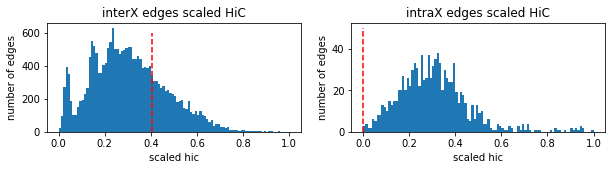

In [349]:
# Plot thresholds
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.hist(adhesome_interX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=t, ymin=0, ymax=600, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('interX edges scaled HiC')

plt.subplot(1, 2, 2)
plt.hist(adhesome_intraX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=0, ymin=0, ymax=50, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('intraX edges scaled HiC')

plt.show()

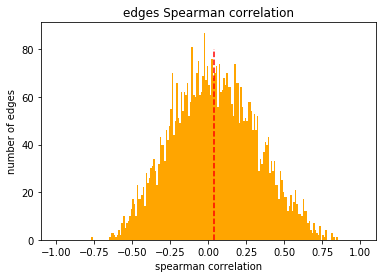

Ttest_1sampResult(statistic=10.671542822333917, pvalue=2.6041640975511676e-26)
KstestResult(statistic=0.05971342601621166, pvalue=2.4261690239831647e-16)


In [350]:
# Plot distribution of Spearman correlation
plt.figure()
plt.hist(adhesome_edge_list['spearman_corr'], 
         bins=np.arange(-1,1.01,0.01),
        color='orange')
plt.vlines(x=np.mean(adhesome_edge_list['spearman_corr']), ymin=0, ymax=80, color='red', linestyle='dashed')
plt.xlabel('spearman correlation')
plt.ylabel('number of edges')
plt.title('edges Spearman correlation')
plt.show()
# Run statistical tests
ttest = ss.ttest_1samp(adhesome_edge_list['spearman_corr'], popmean=0)
print(ttest)
kstest = ss.kstest(adhesome_edge_list['spearman_corr']/np.std(adhesome_edge_list['spearman_corr']), cdf=ss.norm.cdf, alternative='two-sided')
print(kstest)

In [351]:
# Create corresponding network
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
print('Total number of nodes in G = '+str(len(G.nodes)))
print('Total number of edges in G = '+str(len(G.edges)))
print('Average node degree in G = '+str(np.mean(list(dict(G.degree).values()))))
print('Number of connected components in G = '+str(nx.number_connected_components(G)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(G)]))

Total number of nodes in G = 208
Total number of edges in G = 5139
Average node degree in G = 49.41346153846154
Number of connected components in G = 1
Size of connected components = [208]


### Clustering with VOTE+BOEM

In [352]:
# Get cost matrices
A, w_plus, w_minus, w_pm = cc.compute_costs(G, 'spearman_corr')
n = G.number_of_nodes()

In [353]:
# Run VOTE
vote_dict,objective_vals = cc.VOTE(n, w_minus, w_plus, w_pm, n_runs=100, seed=13)

100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


In [355]:
# Run BOEM
boem_dict = cc.BOEM(vote_dict, G.number_of_nodes(), w_minus, w_plus, max_iter=100)
pickle.dump(boem_dict, open('boem_dict.pkl', 'wb'))

  0%|          | 0/208 [00:00<?, ?it/s]

VOTE objective = 191.14774207555362


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 1 objective = 190.66315675206255


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 2 objective = 190.3702778983934


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 3 objective = 190.1054059921841


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 4 objective = 189.9377985236648


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 5 objective = 189.7936387320886


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 6 objective = 189.67705167173253


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 7 objective = 189.43888406426402


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 8 objective = 189.35725141120278


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 9 objective = 189.33380373425967


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 10 objective = 189.31838905775078


100%|██████████| 208/208 [00:50<00:00,  4.08it/s]


In [356]:
# Load results
best_dict = pickle.load(open('boem_dict.pkl', 'rb'))
print('Final VOTE/BOEM objective = '+str(cc.compute_objective_from_dict(best_dict, w_minus, w_plus)))

Final VOTE/BOEM objective = 189.31838905775078


In [357]:
# Result of VOTE+BOEM
k = len(np.unique(list(best_dict.values())))
c_mat = np.matrix(np.concatenate([np.eye(1,k,best_dict[i]) for i in range(n)],axis=0))
x_boem = np.array(c_mat*np.transpose(c_mat))
labels = sorted(G.nodes())
x_df = pd.DataFrame(x_boem, index=labels, columns=labels)

In [358]:
# Final clique graph
np.fill_diagonal(x_df.values, 0)
clique_graph = nx.from_pandas_adjacency(x_df)
# Add cluster information for each node
nx.set_node_attributes(clique_graph, {labels[i]: str(int(best_dict[i])) for i in range(n)}, "cluster")
# Add chromosome information for each node
nx.set_node_attributes(clique_graph, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(clique_graph, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Add scaled HiC information
edgelist_clique = list(clique_graph.edges)
nx.set_edge_attributes(clique_graph, 
                       {edge: G[edge[0]][edge[1]]['scaled_hic'] for edge in G.edges}, 
                       'scaled_hic')
nx.set_edge_attributes(clique_graph, 
                       {edge: 1-G[edge[0]][edge[1]]['scaled_hic'] for edge in G.edges}, 
                       'reciprocal_scaled_hic')

Total number of nodes in clique_graph = 208
Total number of edges in clique_graph = 94
Average node degree in clique_graph = 0.9038461538461539
Number of connected components in clique_graph = 143
Number of nodes in non trivial cliques = 109
Number of singletons = 99
Size of connected components


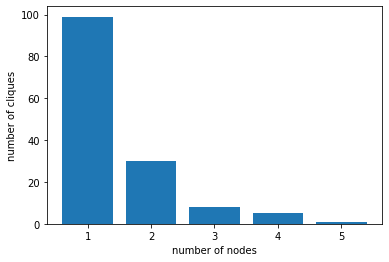

PosixPath('/home/louiscam/projects/gpcr/save/figures/clique_graph.html')

In [359]:
# Clique graph summary
print('Total number of nodes in clique_graph = '+str(len(clique_graph.nodes)))
print('Total number of edges in clique_graph = '+str(len(clique_graph.edges)))
print('Average node degree in clique_graph = '+str(np.mean(list(dict(clique_graph.degree).values()))))
print('Number of connected components in clique_graph = '+str(nx.number_connected_components(clique_graph)))
print('Number of nodes in non trivial cliques = '+str(sum([len(c) for c in nx.connected_components(clique_graph) if len(c)>1])))
print('Number of singletons = '+str(sum([len(c) for c in nx.connected_components(clique_graph) if len(c)==1])))
print('Size of connected components')
plt.figure()
comps = np.unique([len(c) for c in nx.connected_components(clique_graph)], return_counts=True)
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()
# Save network to html
oi.output_networkx_graph_as_interactive_html(clique_graph, filename=saving_dir+"clique_graph.html")

In [363]:
# Record clustering
clustering_graph2_wcc = [int(best_dict[i]) for i in range(n)]
#pickle.dump(clustering_graph1_wcc, open(saving_dir+'clustering_graph1_wcc.pkl', 'wb'))
pickle.dump(clustering_graph2_wcc, open(saving_dir+'clustering_graph1_wcc.pkl', 'wb'))

In [364]:
# Select only components with more than 1 node
selected_nodes = np.sum([list(cc) for cc in nx.connected_components(clique_graph) if len(cc)>1])
clique_subgraph = clique_graph.subgraph(selected_nodes)
# Save network to html
oi.output_networkx_graph_as_interactive_html(clique_subgraph, filename=saving_dir+"clique_subgraph4.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/clique_subgraph4.html')

### Clustering with hierarchical clustering

In [365]:
# Get adjacency matrix of G
A = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='spearman_corr')
A = np.array(A.todense())
A = np.exp(-A)
# Select upper triangular entries and flatten
y = A[np.triu_indices(n=len(A),k=1)]

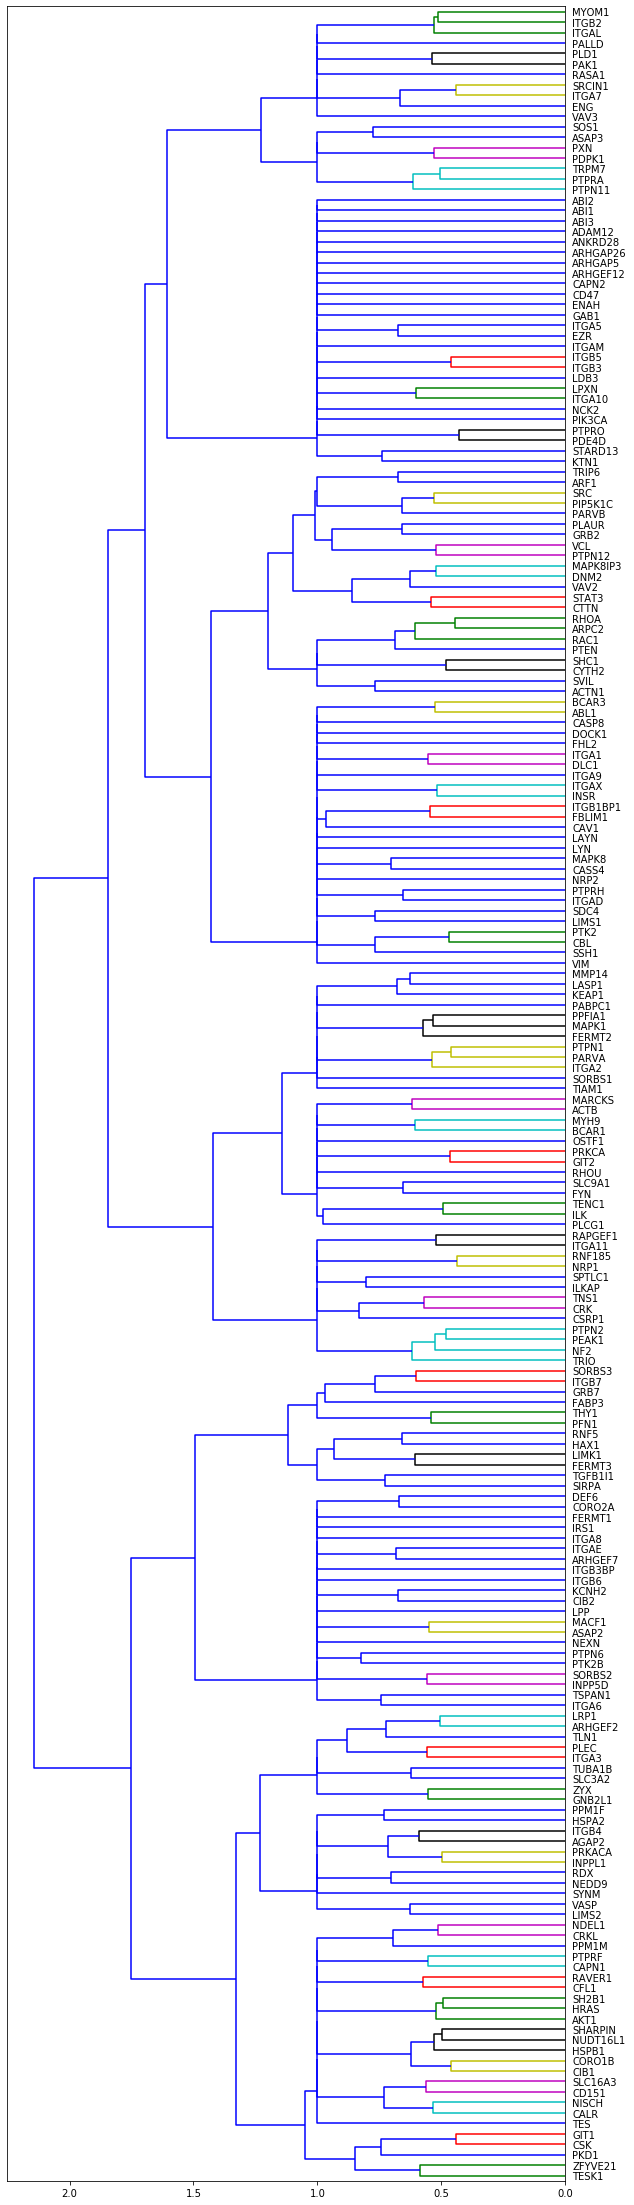

In [366]:
# Hierarchical clustering
linked = linkage(y, method='complete')
# Plot dendrogram
plt.figure(figsize=(10, 40))
dendrogram(linked,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=10,
            color_threshold=0.62)
plt.show()

Number of clusters = 150
Number of singletons = 101
Number of nodes in non trivial clusters = 107
Size of clusters


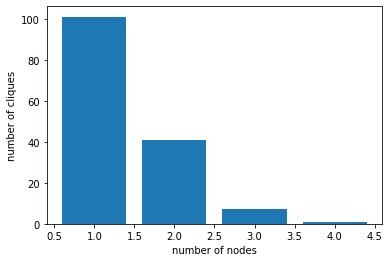

In [378]:
# Record flat clustering
clustering_graph2_hc = fcluster(linked, t=0.62, criterion='distance')
#pickle.dump(clustering_graph1_hc, open(saving_dir+'clustering_graph1_hc.pkl', 'wb'))
pickle.dump(clustering_graph2_hc, open(saving_dir+'clustering_graph1_hc.pkl', 'wb'))
comps = np.unique(np.unique(clustering_graph2_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_graph2_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_hc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

In [ ]:
# Robustness analysis
hic_threshold_list = []

# Sanity checks

In [379]:
# Strongest edges (Spearman correlation)
adhesome_edge_list_sorted = adhesome_edge_list.sort_values(by='spearman_corr', ascending=False)
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659
12643,NRP1,RNF185,1.896217,0.409967,0.827942
4223,CSK,GIT1,2.443617,0.571054,0.819366
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715
2058,ARPC2,RHOA,2.529139,0.596221,0.813830


In [380]:
# Check whether these edges are clustered together in WCC
adhesome_edge_list_sorted['coclustered_wcc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,5] = (clustering_graph2_wcc[index_gene1]==clustering_graph2_wcc[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,False
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False
4223,CSK,GIT1,2.443617,0.571054,0.819366,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,False
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True


In [381]:
# Check whether these edges are clustered together in WCC
adhesome_edge_list_sorted['coclustered_hc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,6] = (clustering_graph2_hc[index_gene1]==clustering_graph2_hc[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,False,True
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,False,True
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True


In [382]:
# Check whether WCC and HCC produce similar clusters
adhesome_edge_list_sorted['hc_wcc_match'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    adhesome_edge_list_sorted.iloc[i,7] = (adhesome_edge_list_sorted.iloc[i,5]==adhesome_edge_list_sorted.iloc[i,6])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,hc_wcc_match
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,False,True,False
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True,False
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,False,True,False
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True,True


In [383]:
# Compute cumsums
adhesome_edge_list_sorted['coclustered_wcc_cumsum'] = adhesome_edge_list_sorted['coclustered_wcc'].astype(int).cumsum()
adhesome_edge_list_sorted['coclustered_hc_cumsum'] = adhesome_edge_list_sorted['coclustered_hc'].astype(int).cumsum()
adhesome_edge_list_sorted['hc_wcc_match_cumsum'] = adhesome_edge_list_sorted['hc_wcc_match'].astype(int).cumsum()
adhesome_edge_list_sorted.head(10)

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,hc_wcc_match,coclustered_wcc_cumsum,coclustered_hc_cumsum,hc_wcc_match_cumsum
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,False,True,False,0,1,0
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True,False,0,2,0
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True,True,1,3,1
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,False,True,False,1,4,1
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True,True,2,5,2
3847,CORO1B,CIB1,2.441792,0.570517,0.778116,False,True,False,2,6,2
9411,ITGB3,ITGB5,1.986165,0.436437,0.775510,False,True,False,2,7,2
13233,PARVA,PTPN1,1.956734,0.427776,0.772905,True,True,True,3,8,3
3647,CIB1,SH2B1,2.223142,0.506173,0.770083,True,False,False,4,8,3
6101,GIT2,PRKCA,1.907407,0.413260,0.767152,False,True,False,4,9,3


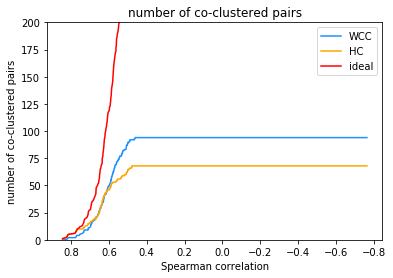

In [384]:
# Plot number of co-clustered pairs versus Spearman correlation
plt.figure()
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_wcc_cumsum'],
         color='dodgerblue', label='WCC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_hc_cumsum'],
         color='orange', label='HC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(adhesome_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Spearman correlation')
plt.ylabel('number of co-clustered pairs')
plt.ylim([0,200])
plt.title('number of co-clustered pairs')
plt.show()

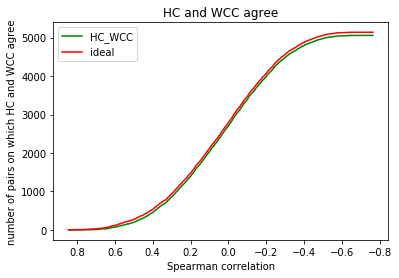

In [385]:
# Plot number of clustered pairs on which HC and WCC agree versus Spearman correlation
plt.figure()
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['hc_wcc_match_cumsum'],
         color='green', label='HC_WCC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(adhesome_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Spearman correlation')
plt.ylabel('number of pairs on which HC and WCC agree')
plt.title('HC and WCC agree')
plt.show()

In [387]:
# Adjusted mutual information
adjusted_mutual_info_score(labels_true=clustering_graph2_wcc,
                           labels_pred=clustering_graph2_hc, 
                           average_method='min')

0.596466874681471

# Network analysis - with adhesome TFs

### Network of adhesome genes: interX edges

### Network of adhesome genes: intraX edges

### Network of adhesome genes: interX and intraX

In [37]:
# Load edge lists
adhesome_interX_edge_list = pickle.load(open(saving_dir+'adhesome_interX_edge_list.pkl', 'rb'))
adhesome_intraX_edge_list = pickle.load(open(saving_dir+'adhesome_intraX_edge_list.pkl', 'rb'))

### Genomic features for each adhesome gene

In [38]:
# Load pairwise Spearman correlations between adhesome genes
adhesome_loc_corr = pickle.load(open(saving_dir+'adhesome_loc_corr.pkl','rb'))

In [39]:
# Add Spearman correlation to interX edge list
adhesome_interX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                    adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
adhesome_interX_edge_list.head()

,source,target,hic,scaled_hic,spearman_corr
0,ABI1,ABI2,0.913088,0.120655,0.440947
1,ABI1,ABL1,0.874730,0.109367,0.313721
2,ABI1,ACTB,1.079872,0.169735,-0.273448
3,ABI1,ACTN1,1.480107,0.287516,-0.087169
4,ABI1,AGAP2,0.672833,0.049953,-0.365067


In [40]:
# Add Spearman correlation to intraX edge list
adhesome_intraX_edge_list['spearman_corr'] = [adhesome_loc_corr.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                    adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]
adhesome_intraX_edge_list.head()

,source,target,hic,chrom,gen_dist,scaled_hic,spearman_corr
0,ABI1,ADAM12,2.312062,10,403.188976,0.135472,0.013026
1,ABI1,DOCK1,2.671161,10,407.318524,0.178049,0.402736
2,ABI1,LDB3,3.537248,10,245.477418,0.280739,-0.267260
3,ABI1,MAPK8,4.011600,10,90.134594,0.336982,0.291468
4,ABI1,NRP1,4.410741,10,25.809422,0.384307,0.059162


# Clustering analysis 1/4

### Construct network

In [348]:
# Select only top interX and intraX edges
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],0.75)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],0.75)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','spearman_corr']]
print('Number of interX edges selected = '+str(len(inter_selected)))
print('Number of intraX edges selected = '+str(len(intra_selected)))
#adhesome_edge_list = pd.concat([inter_selected,intra_selected])
adhesome_edge_list = inter_selected
adhesome_edge_list.head()

Number of interX edges selected = 5139
Number of intraX edges selected = 261


,source,target,hic,scaled_hic,spearman_corr
68,ABI1,ITGAE,2.056018,0.456993,-0.206470
96,ABI1,MMP14,2.165441,0.489193,0.089774
101,ABI1,NEDD9,1.957505,0.428003,0.136887
106,ABI1,NUDT16L1,2.114121,0.474091,-0.365067
132,ABI1,PTPN11,1.927031,0.419035,0.337386


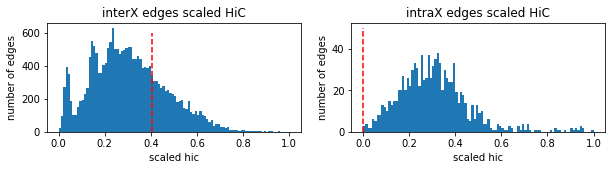

In [349]:
# Plot thresholds
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.hist(adhesome_interX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=t, ymin=0, ymax=600, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('interX edges scaled HiC')

plt.subplot(1, 2, 2)
plt.hist(adhesome_intraX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
plt.vlines(x=0, ymin=0, ymax=50, 
           color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('intraX edges scaled HiC')

plt.show()

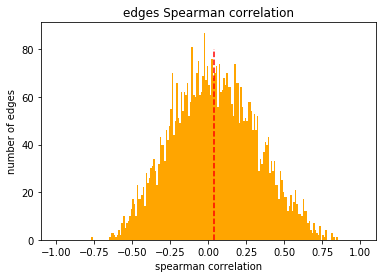

Ttest_1sampResult(statistic=10.671542822333917, pvalue=2.6041640975511676e-26)
KstestResult(statistic=0.05971342601621166, pvalue=2.4261690239831647e-16)


In [350]:
# Plot distribution of Spearman correlation
plt.figure()
plt.hist(adhesome_edge_list['spearman_corr'], 
         bins=np.arange(-1,1.01,0.01),
        color='orange')
plt.vlines(x=np.mean(adhesome_edge_list['spearman_corr']), ymin=0, ymax=80, color='red', linestyle='dashed')
plt.xlabel('spearman correlation')
plt.ylabel('number of edges')
plt.title('edges Spearman correlation')
plt.show()
# Run statistical tests
ttest = ss.ttest_1samp(adhesome_edge_list['spearman_corr'], popmean=0)
print(ttest)
kstest = ss.kstest(adhesome_edge_list['spearman_corr']/np.std(adhesome_edge_list['spearman_corr']), cdf=ss.norm.cdf, alternative='two-sided')
print(kstest)

In [351]:
# Create corresponding network
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','spearman_corr'])
print('Total number of nodes in G = '+str(len(G.nodes)))
print('Total number of edges in G = '+str(len(G.edges)))
print('Average node degree in G = '+str(np.mean(list(dict(G.degree).values()))))
print('Number of connected components in G = '+str(nx.number_connected_components(G)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(G)]))

Total number of nodes in G = 208
Total number of edges in G = 5139
Average node degree in G = 49.41346153846154
Number of connected components in G = 1
Size of connected components = [208]


### Clustering with VOTE+BOEM

In [352]:
# Get cost matrices
A, w_plus, w_minus, w_pm = cc.compute_costs(G, 'spearman_corr')
n = G.number_of_nodes()

In [353]:
# Run VOTE
vote_dict,objective_vals = cc.VOTE(n, w_minus, w_plus, w_pm, n_runs=100, seed=13)

100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


In [355]:
# Run BOEM
boem_dict = cc.BOEM(vote_dict, G.number_of_nodes(), w_minus, w_plus, max_iter=100)
pickle.dump(boem_dict, open('boem_dict.pkl', 'wb'))

  0%|          | 0/208 [00:00<?, ?it/s]

VOTE objective = 191.14774207555362


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 1 objective = 190.66315675206255


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 2 objective = 190.3702778983934


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 3 objective = 190.1054059921841


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 4 objective = 189.9377985236648


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 5 objective = 189.7936387320886


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 6 objective = 189.67705167173253


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 7 objective = 189.43888406426402


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 8 objective = 189.35725141120278


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 9 objective = 189.33380373425967


  0%|          | 0/208 [00:00<?, ?it/s]

VOTE+BOEM 10 objective = 189.31838905775078


100%|██████████| 208/208 [00:50<00:00,  4.08it/s]


In [356]:
# Load results
best_dict = pickle.load(open('boem_dict.pkl', 'rb'))
print('Final VOTE/BOEM objective = '+str(cc.compute_objective_from_dict(best_dict, w_minus, w_plus)))

Final VOTE/BOEM objective = 189.31838905775078


In [357]:
# Result of VOTE+BOEM
k = len(np.unique(list(best_dict.values())))
c_mat = np.matrix(np.concatenate([np.eye(1,k,best_dict[i]) for i in range(n)],axis=0))
x_boem = np.array(c_mat*np.transpose(c_mat))
labels = sorted(G.nodes())
x_df = pd.DataFrame(x_boem, index=labels, columns=labels)

In [358]:
# Final clique graph
np.fill_diagonal(x_df.values, 0)
clique_graph = nx.from_pandas_adjacency(x_df)
# Add cluster information for each node
nx.set_node_attributes(clique_graph, {labels[i]: str(int(best_dict[i])) for i in range(n)}, "cluster")
# Add chromosome information for each node
nx.set_node_attributes(clique_graph, {labels[i]: adhesome_chr_loci[adhesome_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add functional category for each node
nx.set_node_attributes(clique_graph, {labels[i]: df_components[df_components['geneSymbol']==labels[i]]['functionalCategory'].values[0] 
                                      for i in range(n)}, "function")
# Add scaled HiC information
edgelist_clique = list(clique_graph.edges)
nx.set_edge_attributes(clique_graph, 
                       {edge: G[edge[0]][edge[1]]['scaled_hic'] for edge in G.edges}, 
                       'scaled_hic')
nx.set_edge_attributes(clique_graph, 
                       {edge: 1-G[edge[0]][edge[1]]['scaled_hic'] for edge in G.edges}, 
                       'reciprocal_scaled_hic')

Total number of nodes in clique_graph = 208
Total number of edges in clique_graph = 94
Average node degree in clique_graph = 0.9038461538461539
Number of connected components in clique_graph = 143
Number of nodes in non trivial cliques = 109
Number of singletons = 99
Size of connected components


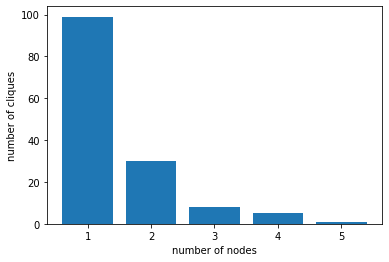

PosixPath('/home/louiscam/projects/gpcr/save/figures/clique_graph.html')

In [359]:
# Clique graph summary
print('Total number of nodes in clique_graph = '+str(len(clique_graph.nodes)))
print('Total number of edges in clique_graph = '+str(len(clique_graph.edges)))
print('Average node degree in clique_graph = '+str(np.mean(list(dict(clique_graph.degree).values()))))
print('Number of connected components in clique_graph = '+str(nx.number_connected_components(clique_graph)))
print('Number of nodes in non trivial cliques = '+str(sum([len(c) for c in nx.connected_components(clique_graph) if len(c)>1])))
print('Number of singletons = '+str(sum([len(c) for c in nx.connected_components(clique_graph) if len(c)==1])))
print('Size of connected components')
plt.figure()
comps = np.unique([len(c) for c in nx.connected_components(clique_graph)], return_counts=True)
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()
# Save network to html
oi.output_networkx_graph_as_interactive_html(clique_graph, filename=saving_dir+"clique_graph.html")

In [363]:
# Record clustering
clustering_graph2_wcc = [int(best_dict[i]) for i in range(n)]
#pickle.dump(clustering_graph1_wcc, open(saving_dir+'clustering_graph1_wcc.pkl', 'wb'))
pickle.dump(clustering_graph2_wcc, open(saving_dir+'clustering_graph1_wcc.pkl', 'wb'))

In [364]:
# Select only components with more than 1 node
selected_nodes = np.sum([list(cc) for cc in nx.connected_components(clique_graph) if len(cc)>1])
clique_subgraph = clique_graph.subgraph(selected_nodes)
# Save network to html
oi.output_networkx_graph_as_interactive_html(clique_subgraph, filename=saving_dir+"clique_subgraph4.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/clique_subgraph4.html')

### Clustering with hierarchical clustering

In [365]:
# Get adjacency matrix of G
A = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='spearman_corr')
A = np.array(A.todense())
A = np.exp(-A)
# Select upper triangular entries and flatten
y = A[np.triu_indices(n=len(A),k=1)]

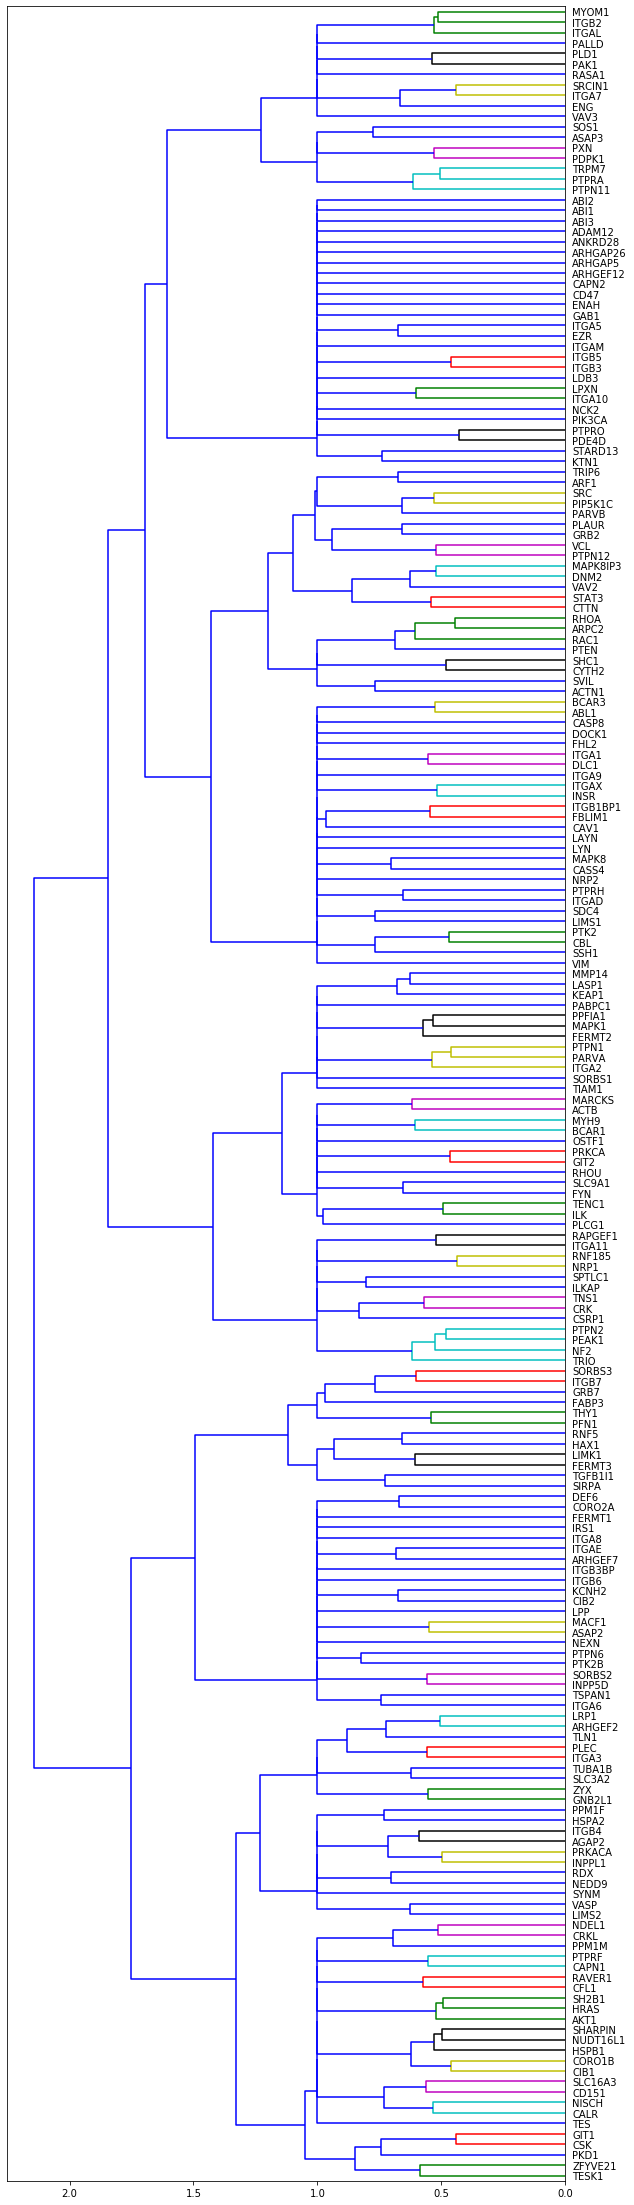

In [366]:
# Hierarchical clustering
linked = linkage(y, method='complete')
# Plot dendrogram
plt.figure(figsize=(10, 40))
dendrogram(linked,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=10,
            color_threshold=0.62)
plt.show()

Number of clusters = 150
Number of singletons = 101
Number of nodes in non trivial clusters = 107
Size of clusters


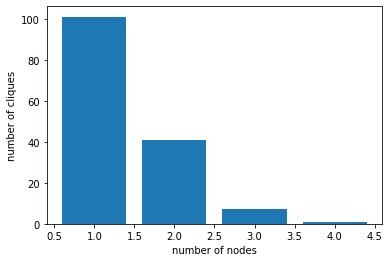

In [378]:
# Record flat clustering
clustering_graph2_hc = fcluster(linked, t=0.62, criterion='distance')
#pickle.dump(clustering_graph1_hc, open(saving_dir+'clustering_graph1_hc.pkl', 'wb'))
pickle.dump(clustering_graph2_hc, open(saving_dir+'clustering_graph1_hc.pkl', 'wb'))
comps = np.unique(np.unique(clustering_graph2_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_graph2_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_hc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

# Sanity checks

In [379]:
# Strongest edges (Spearman correlation)
adhesome_edge_list_sorted = adhesome_edge_list.sort_values(by='spearman_corr', ascending=False)
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659
12643,NRP1,RNF185,1.896217,0.409967,0.827942
4223,CSK,GIT1,2.443617,0.571054,0.819366
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715
2058,ARPC2,RHOA,2.529139,0.596221,0.813830


In [380]:
# Check whether these edges are clustered together in WCC
adhesome_edge_list_sorted['coclustered_wcc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,5] = (clustering_graph2_wcc[index_gene1]==clustering_graph2_wcc[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,False
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False
4223,CSK,GIT1,2.443617,0.571054,0.819366,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,False
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True


In [381]:
# Check whether these edges are clustered together in WCC
adhesome_edge_list_sorted['coclustered_hc'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    index_gene1 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,0])[0])
    index_gene2 = int(np.where(np.array(sorted(G.nodes))==adhesome_edge_list_sorted.iloc[i,1])[0])
    adhesome_edge_list_sorted.iloc[i,6] = (clustering_graph2_hc[index_gene1]==clustering_graph2_hc[index_gene2])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,False,True
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,False,True
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True


In [382]:
# Check whether WCC and HCC produce similar clusters
adhesome_edge_list_sorted['hc_wcc_match'] = 0
for i in range(len(adhesome_edge_list_sorted)):
    adhesome_edge_list_sorted.iloc[i,7] = (adhesome_edge_list_sorted.iloc[i,5]==adhesome_edge_list_sorted.iloc[i,6])
adhesome_edge_list_sorted.head()

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,hc_wcc_match
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,False,True,False
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True,False
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True,True
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,False,True,False
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True,True


In [383]:
# Compute cumsums
adhesome_edge_list_sorted['coclustered_wcc_cumsum'] = adhesome_edge_list_sorted['coclustered_wcc'].astype(int).cumsum()
adhesome_edge_list_sorted['coclustered_hc_cumsum'] = adhesome_edge_list_sorted['coclustered_hc'].astype(int).cumsum()
adhesome_edge_list_sorted['hc_wcc_match_cumsum'] = adhesome_edge_list_sorted['hc_wcc_match'].astype(int).cumsum()
adhesome_edge_list_sorted.head(10)

,source,target,hic,scaled_hic,spearman_corr,coclustered_wcc,coclustered_hc,hc_wcc_match,coclustered_wcc_cumsum,coclustered_hc_cumsum,hc_wcc_match_cumsum
15915,PTPRO,PDE4D,2.330510,0.537769,0.844659,False,True,False,0,1,0
12643,NRP1,RNF185,1.896217,0.409967,0.827942,False,True,False,0,2,0
4223,CSK,GIT1,2.443617,0.571054,0.819366,True,True,True,1,3,1
8267,ITGA7,SRCIN1,1.961757,0.429254,0.818715,False,True,False,1,4,1
2058,ARPC2,RHOA,2.529139,0.596221,0.813830,True,True,True,2,5,2
3847,CORO1B,CIB1,2.441792,0.570517,0.778116,False,True,False,2,6,2
9411,ITGB3,ITGB5,1.986165,0.436437,0.775510,False,True,False,2,7,2
13233,PARVA,PTPN1,1.956734,0.427776,0.772905,True,True,True,3,8,3
3647,CIB1,SH2B1,2.223142,0.506173,0.770083,True,False,False,4,8,3
6101,GIT2,PRKCA,1.907407,0.413260,0.767152,False,True,False,4,9,3


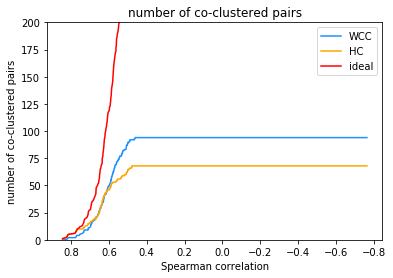

In [384]:
# Plot number of co-clustered pairs versus Spearman correlation
plt.figure()
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_wcc_cumsum'],
         color='dodgerblue', label='WCC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['coclustered_hc_cumsum'],
         color='orange', label='HC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(adhesome_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Spearman correlation')
plt.ylabel('number of co-clustered pairs')
plt.ylim([0,200])
plt.title('number of co-clustered pairs')
plt.show()

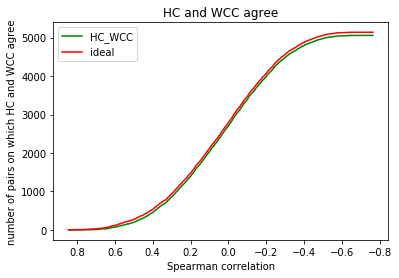

In [385]:
# Plot number of clustered pairs on which HC and WCC agree versus Spearman correlation
plt.figure()
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         adhesome_edge_list_sorted['hc_wcc_match_cumsum'],
         color='green', label='HC_WCC')
plt.plot(adhesome_edge_list_sorted['spearman_corr'],
         np.cumsum(np.repeat(1,len(adhesome_edge_list_sorted))),
         color='red', label='ideal')
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('Spearman correlation')
plt.ylabel('number of pairs on which HC and WCC agree')
plt.title('HC and WCC agree')
plt.show()

In [387]:
# Adjusted mutual information
adjusted_mutual_info_score(labels_true=clustering_graph2_wcc,
                           labels_pred=clustering_graph2_hc, 
                           average_method='min')

0.596466874681471